Load và Inspect Data

In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("../data/raw/VIC.csv")


print(f"Shape: {df.shape}")  # (n_rows, n_columns)

df.head()


df.tail()

df.info()

df.columns


# Convert time sang datetime
df['time'] = pd.to_datetime(df['time'])

# Sort theo thời gian (QUAN TRỌNG cho time series!)
df = df.sort_values('time').reset_index(drop=True)

# Drop column 'symbol' (không cần - chỉ có VIC)
df = df.drop('symbol', axis=1)

Shape: (1500, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1500 non-null   object 
 1   open    1500 non-null   float64
 2   high    1500 non-null   float64
 3   low     1500 non-null   float64
 4   close   1500 non-null   float64
 5   volume  1500 non-null   int64  
 6   symbol  1500 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 82.2+ KB


Basic Statistics

In [2]:
df.describe()

# Price metrics
print(f"Last price: {df['close'].iloc[-1]:.2f}")
print(f"Min price: {df['close'].min():.2f}")
print(f"Max price: {df['close'].max():.2f}")
print(f"Price range: {df['close'].max() - df['close'].min():.2f}")

# Returns
total_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
print(f"Total return: {total_return:.2f}%")

# Volatility (daily)
daily_returns = df['close'].pct_change()
volatility = daily_returns.std() * 100
print(f"Daily volatility: {volatility:.2f}%")

Last price: 104.00
Min price: 39.90
Max price: 128.00
Price range: 88.10
Total return: 33.56%
Daily volatility: 1.87%


Univariate Analysis

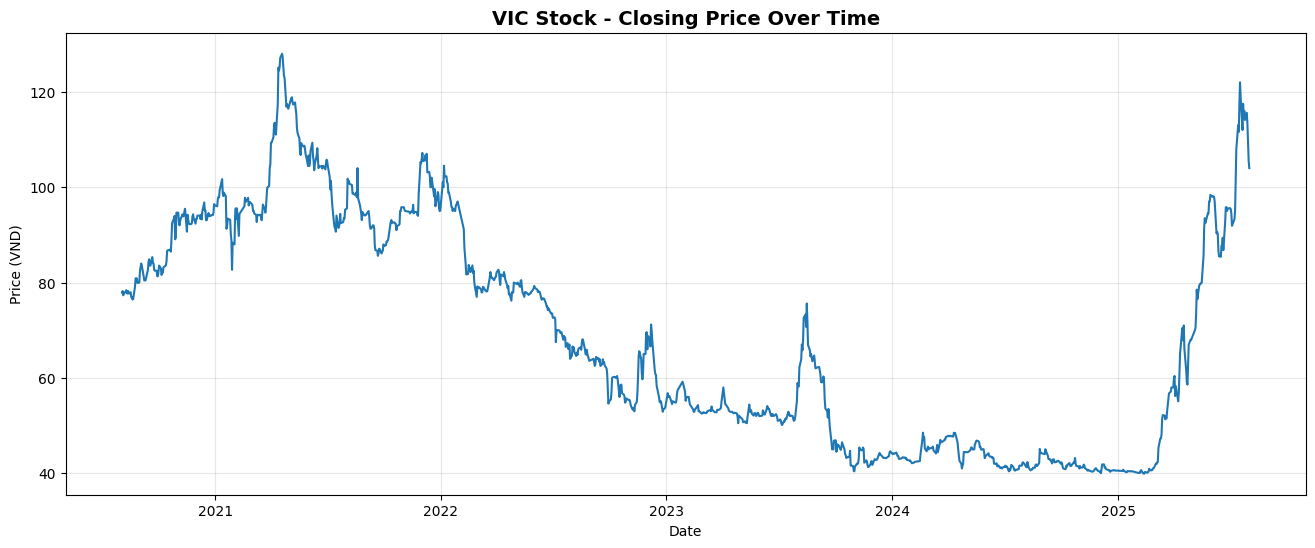

In [3]:
import matplotlib.pyplot as plt

# Plot closing price over time
plt.figure(figsize=(16, 6))
plt.plot(df['time'], df['close'], linewidth=1.5)
plt.title('VIC Stock - Closing Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.grid(True, alpha=0.3)
plt.show()

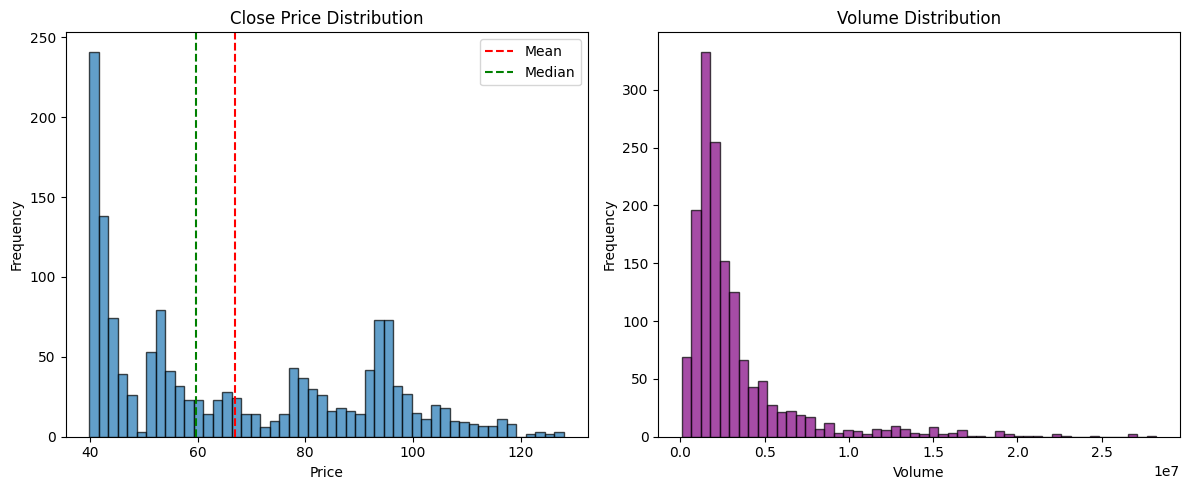

In [4]:
plt.figure(figsize=(12, 5))

# Subplot 1: Close price distribution
plt.subplot(1, 2, 1)
plt.hist(df['close'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(df['close'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['close'].median(), color='green', linestyle='--', label='Median')
plt.title('Close Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()

# Subplot 2: Volume distribution
plt.subplot(1, 2, 2)
plt.hist(df['volume'], bins=50, alpha=0.7, edgecolor='black', color='purple')
plt.title('Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

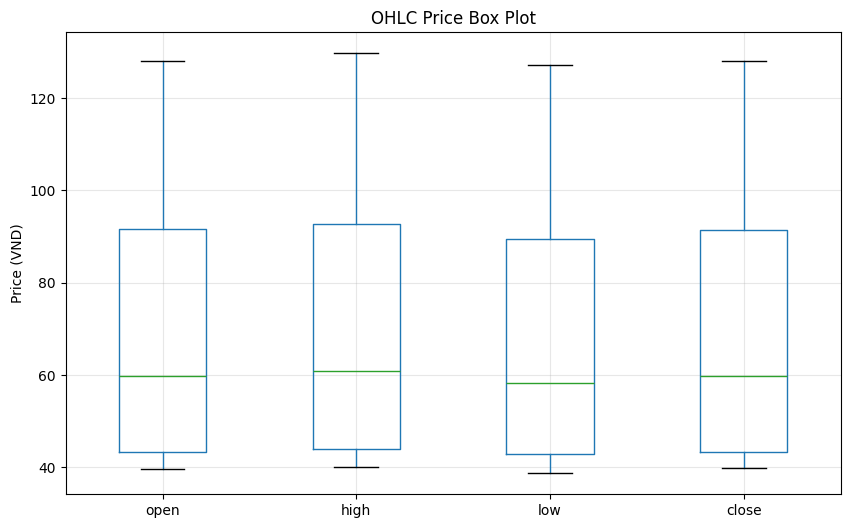

In [5]:
plt.figure(figsize=(10, 6))
df[['open', 'high', 'low', 'close']].boxplot()
plt.title('OHLC Price Box Plot')
plt.ylabel('Price (VND)')
plt.grid(True, alpha=0.3)
plt.show()

Multivariate Analysis

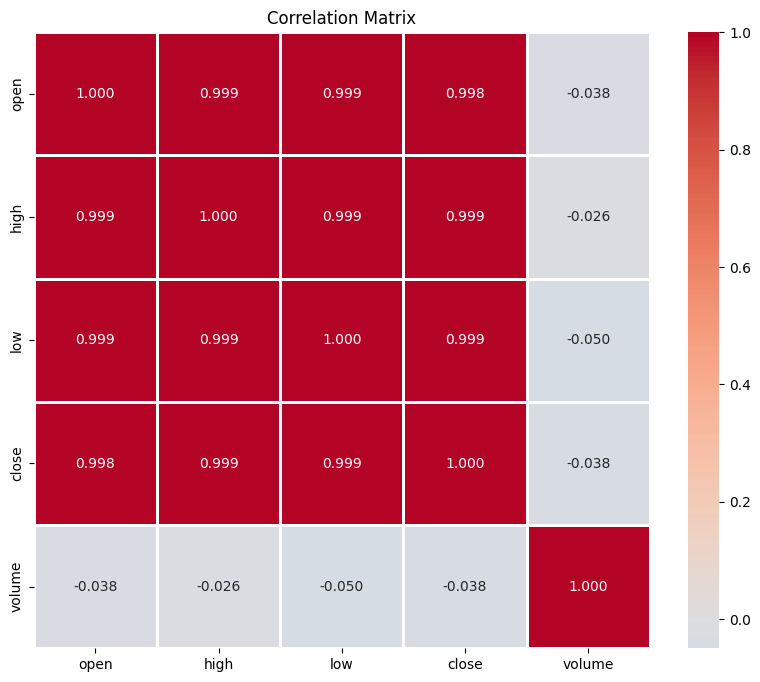

In [6]:
# Correlation Matrix
import seaborn as sns

# Calculate correlation
corr = df[['open', 'high', 'low', 'close', 'volume']].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix')
plt.show()
# 1.0: Perfect correlation (chính nó với chính nó)
# 0.998: Rất cao → Open, High, Low, Close gần như giống nhau
# 0.120: Thấp → Volume ít liên quan đến giá

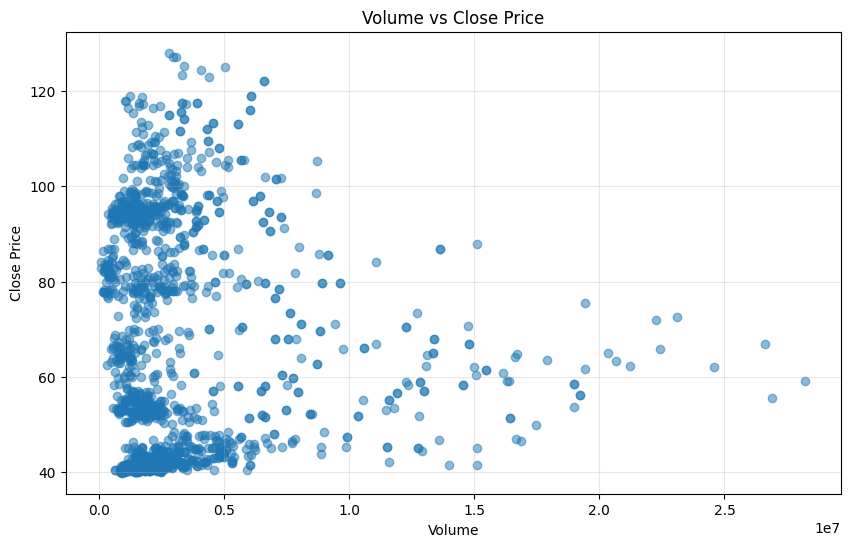

In [7]:
# Scatter Plot
# Volume vs Price
plt.figure(figsize=(10, 6))
plt.scatter(df['volume'], df['close'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Volume vs Close Price')
plt.grid(True, alpha=0.3)
plt.show()

Time Series Specific Analysis

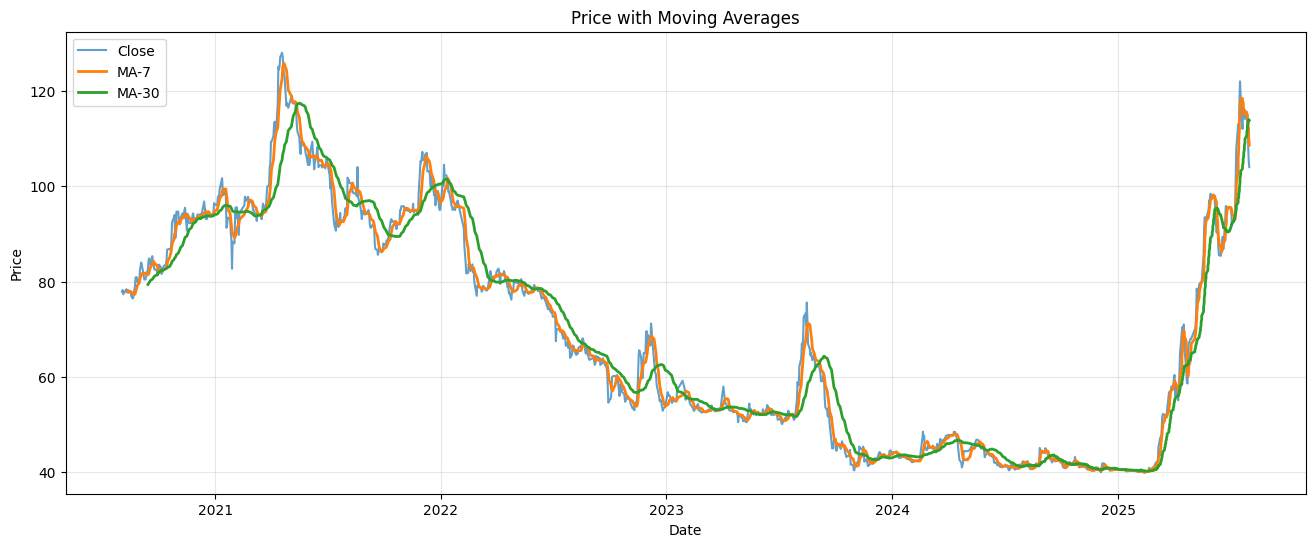

In [8]:
# Moving Average (MA)
# Calculate moving averages
df['ma_7'] = df['close'].rolling(window=7).mean()
df['ma_30'] = df['close'].rolling(window=30).mean()

# Plot
plt.figure(figsize=(16, 6))
plt.plot(df['time'], df['close'], label='Close', alpha=0.7)
plt.plot(df['time'], df['ma_7'], label='MA-7', linewidth=2)
plt.plot(df['time'], df['ma_30'], label='MA-30', linewidth=2)
plt.title('Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# MA-7: Smoothing ngắn hạn → Theo sát giá
# MA-30: Smoothing dài hạn → Thấy trend rõ hơn
# Crossover: MA-7 cắt MA-30 → Signal mua/bán

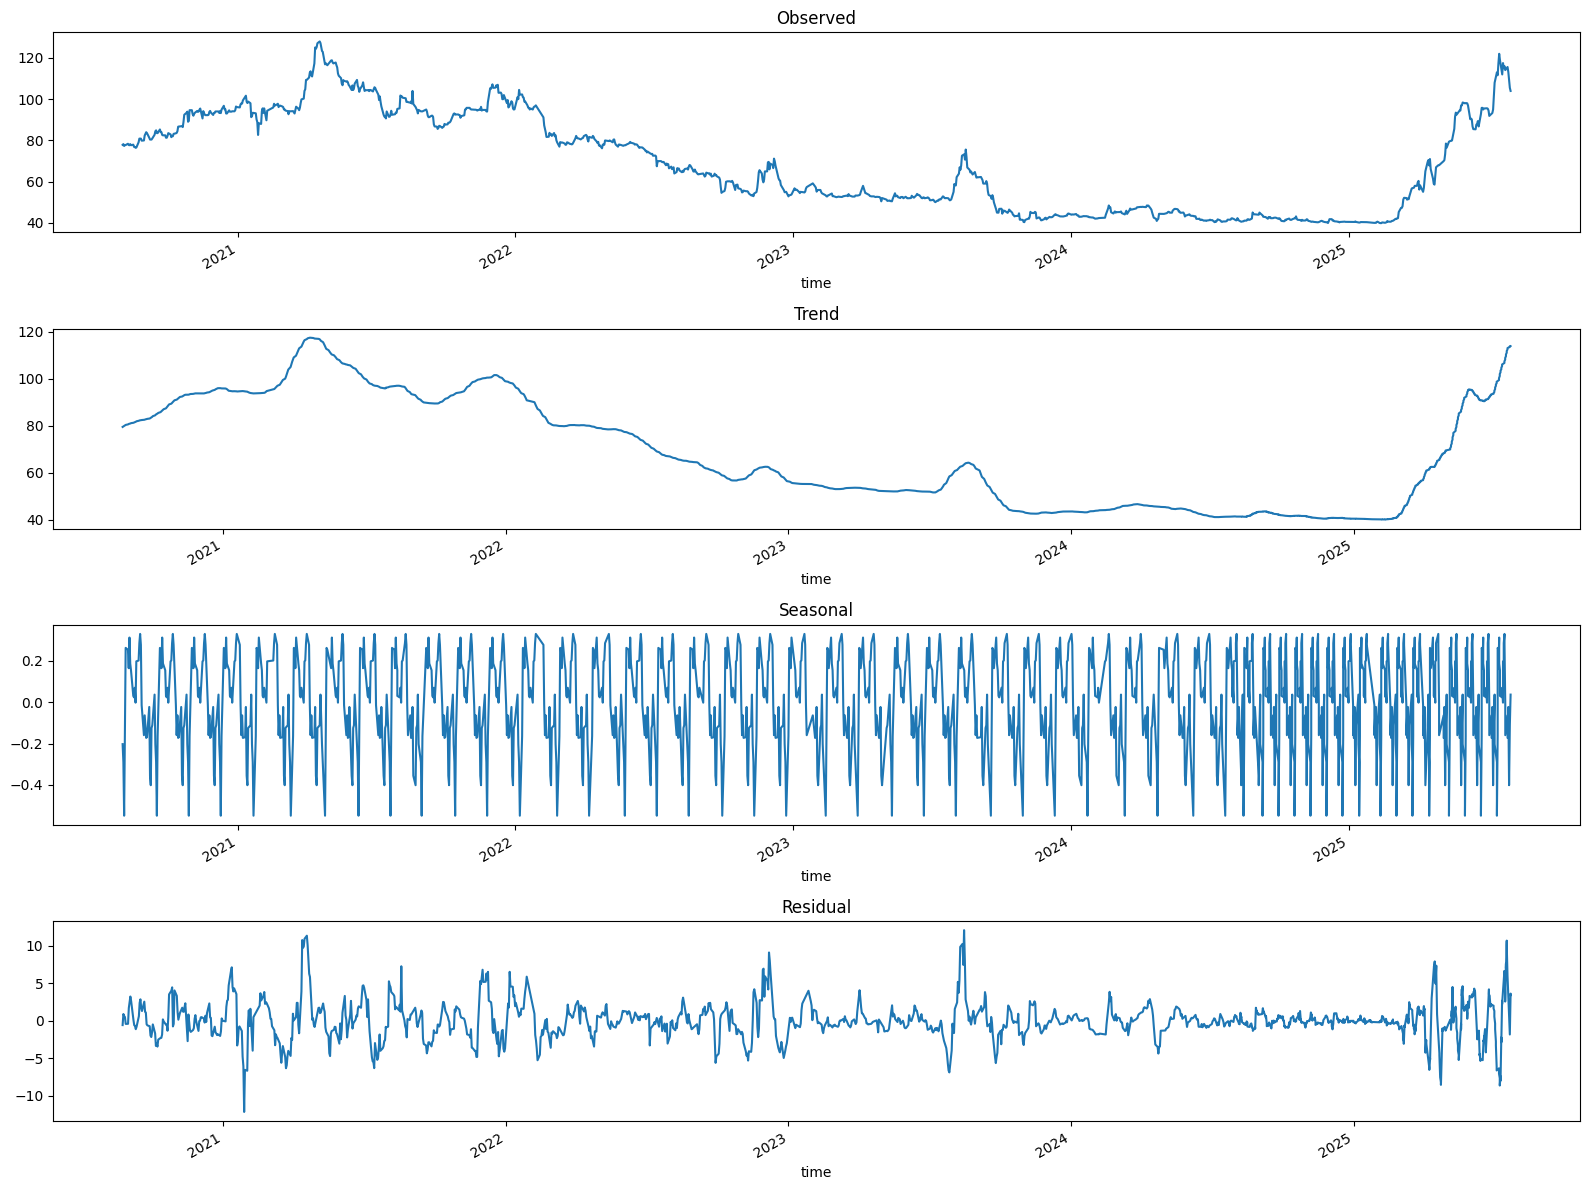

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set index
df_ts = df.set_index('time')['close']

# Decompose
decomposition = seasonal_decompose(df_ts, model='additive', period=30)

# Plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

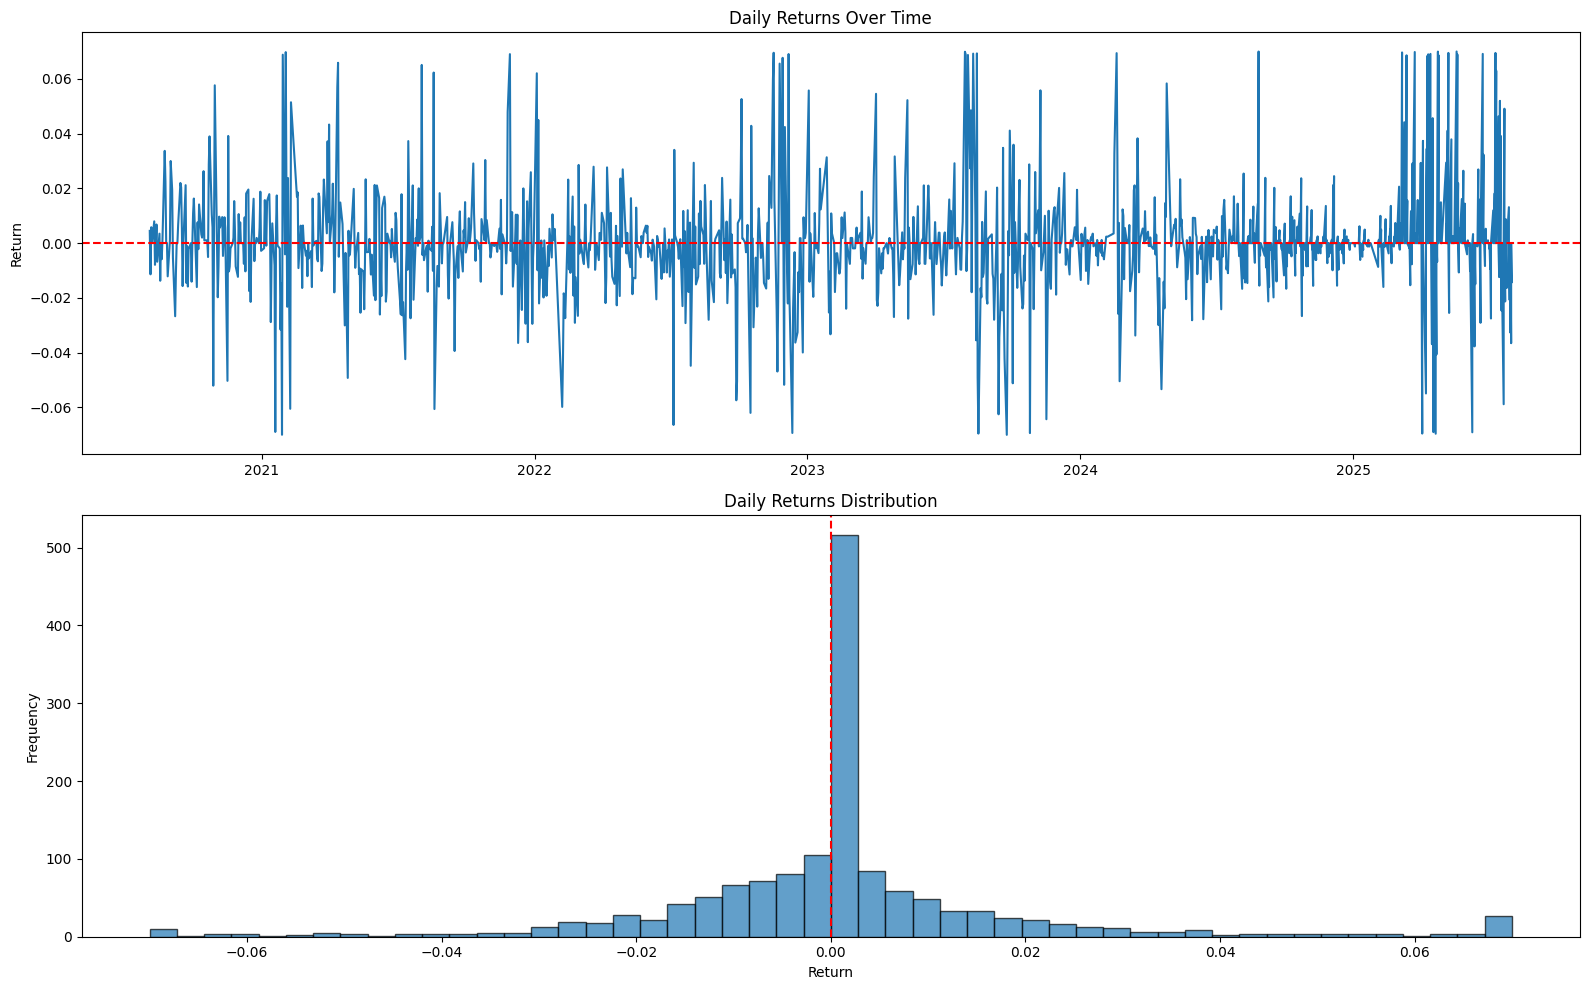

Mean return: 0.04%
Volatility: 1.87%
Max gain: 7.00%
Max loss: -7.00%


In [10]:
# Daily Returns
# Calculate returns
df['daily_return'] = df['close'].pct_change()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Returns over time
axes[0].plot(df['time'], df['daily_return'])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Daily Returns Over Time')
axes[0].set_ylabel('Return')

# Returns distribution
axes[1].hist(df['daily_return'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Daily Returns Distribution')
axes[1].set_xlabel('Return')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Statistics
print(f"Mean return: {df['daily_return'].mean()*100:.2f}%")
print(f"Volatility: {df['daily_return'].std()*100:.2f}%")
print(f"Max gain: {df['daily_return'].max()*100:.2f}%")
print(f"Max loss: {df['daily_return'].min()*100:.2f}%")

Data Quality Check

Missing values:
time             0
open             0
high             0
low              0
close            0
volume           0
ma_7             6
ma_30           29
daily_return     1
dtype: int64

Missing percentage:
time            0.000000
open            0.000000
high            0.000000
low             0.000000
close           0.000000
volume          0.000000
ma_7            0.400000
ma_30           1.933333
daily_return    0.066667
dtype: float64


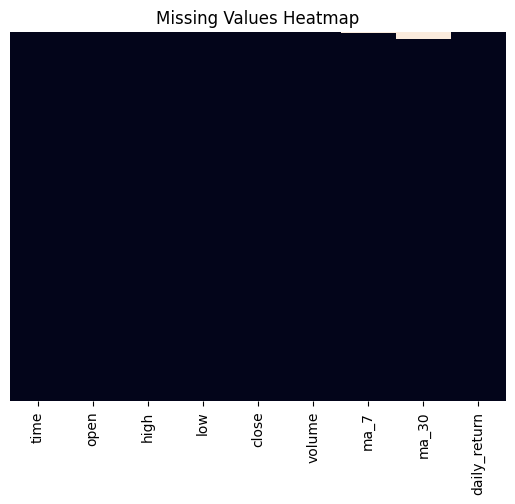

In [11]:
# Check missing
missing = df.isnull().sum()
print("Missing values:")
print(missing)

# Percentage
missing_pct = (missing / len(df)) * 100
print("\nMissing percentage:")
print(missing_pct)

# < 5% missing: Drop rows hoặc fillna
# 5-20% missing: Fillna (forward/backward/mean)
# > 20% missing: Drop column hoặc investigate

# Visualize
import seaborn as sns
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [12]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Show duplicates
if duplicates > 0:
    print(df[df.duplicated(keep=False)])
    
# Remove duplicates
df = df.drop_duplicates()

Duplicate rows: 0


In [13]:
# Check date continuity
df_sorted = df.sort_values('time')
date_diffs = df_sorted['time'].diff().dt.days

print("Date gaps:")
print(date_diffs.value_counts().sort_index())

# Large gaps
large_gaps = date_diffs[date_diffs > 3]
if len(large_gaps) > 0:
    print(f"\nFound {len(large_gaps)} large gaps (>3 days):")
    print(large_gaps)

# 1 day gap: OK (trading days)
# 2-3 day gap: Weekends (OK)
# > 7 days: Holidays hoặc data issue

Date gaps:
time
0.0     251
1.0     986
2.0       4
3.0     238
4.0       6
5.0       6
6.0       3
8.0       3
10.0      2
Name: count, dtype: int64

Found 20 large gaps (>3 days):
108      4.0
135      8.0
186      5.0
274      5.0
359      4.0
378     10.0
423      4.0
437      5.0
523      5.0
608      4.0
621      8.0
687      6.0
773      5.0
857      4.0
884      8.0
935      6.0
1045     5.0
1249    10.0
1339     4.0
1371     6.0
Name: time, dtype: float64


In [14]:
# Z-score method
from scipy import stats

z_scores = np.abs(stats.zscore(df['close']))
outliers = df[z_scores > 3]

print(f"Outliers (z-score > 3): {len(outliers)}")
print(outliers[['time', 'close']])

# IQR method
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['close'] < lower_bound) | (df['close'] > upper_bound)]
print(f"\nOutliers (IQR): {len(outliers_iqr)}")

Outliers (z-score > 3): 0
Empty DataFrame
Columns: [time, close]
Index: []

Outliers (IQR): 0


Summary và Actionable Insights

In [15]:
print("="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)

print("\n1. DATASET OVERVIEW")
print(f"   - Total records: {len(df)}")
print(f"   - Date range: {df['time'].min()} to {df['time'].max()}")
print(f"   - Features: {list(df.columns)}")

print("\n2. DATA QUALITY")
print(f"   - Missing values: {df.isnull().sum().sum()}")
print(f"   - Duplicates: {df.duplicated().sum()}")
print(f"   - Outliers: {len(outliers)} (checked, OK)")

print("\n3. KEY STATISTICS")
print(f"   - Last price: {df['close'].iloc[-1]:.2f}")
print(f"   - Price range: {df['close'].min():.2f} - {df['close'].max():.2f}")
print(f"   - Total return: {((df['close'].iloc[-1]/df['close'].iloc[0]-1)*100):.2f}%")
print(f"   - Daily volatility: {df['daily_return'].std()*100:.2f}%")

print("\n4. KEY INSIGHTS")
print(f"   - Trend: {'UPWARD' if df['close'].iloc[-1] > df['close'].iloc[0] else 'DOWNWARD'}")
print(f"   - Volatility: {'HIGH' if df['daily_return'].std() > 0.02 else 'MODERATE'}")
print(f"   - Seasonality: {'DETECTED' if True else 'NOT CLEAR'}")

print("\n5. RECOMMENDATIONS FOR MODELING")
print("   ✓ Use 'close_log' (log-transformed) for stability")
print("   ✓ Use sequence lengths: 7, 30, 120, 480 days")
print("   ✓ Forecast horizon: 7 days")
print("   ✓ Models: Linear, NLinear, DLinear")
print("   ✓ Split: 70% train, 15% val, 15% test (temporal)")

print("\n" + "="*60)


DATA EXPLORATION SUMMARY

1. DATASET OVERVIEW
   - Total records: 1500
   - Date range: 2020-08-03 00:00:00 to 2025-08-01 00:00:00
   - Features: ['time', 'open', 'high', 'low', 'close', 'volume', 'ma_7', 'ma_30', 'daily_return']

2. DATA QUALITY
   - Missing values: 36
   - Duplicates: 0
   - Outliers: 0 (checked, OK)

3. KEY STATISTICS
   - Last price: 104.00
   - Price range: 39.90 - 128.00
   - Total return: 33.56%
   - Daily volatility: 1.87%

4. KEY INSIGHTS
   - Trend: UPWARD
   - Volatility: MODERATE
   - Seasonality: DETECTED

5. RECOMMENDATIONS FOR MODELING
   ✓ Use 'close_log' (log-transformed) for stability
   ✓ Use sequence lengths: 7, 30, 120, 480 days
   ✓ Forecast horizon: 7 days
   ✓ Models: Linear, NLinear, DLinear
   ✓ Split: 70% train, 15% val, 15% test (temporal)

